In [116]:
import os
import sys

print(os.getcwd())
cwd0 = '../config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)
import tools4PytChem as t4p

/home/romuald/ENSEIGNEMENT/0-JupyterNotebooks/PytChem/UnderDevelopment


**Start at:** Monday 20 February 2023, 17:20:24  
**Hostname:** insa-12842 (Linux)

<p style="text-align: center"><img width="800px" src="../config/svg/PytChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

# VUV simulation from TDDFT calculations. The BIPS case

## 2D and 3D models

In [117]:
from jupyter_jsmol import JsmolView
from ipywidgets import Layout, widgets, interact, Box

<img src="./BIPS/Figs/BIPS-isomerisation.png" style="margin-left:auto; margin-right:auto; display: block; width:700px" id="img_isomerisationBIPS2D" alt="isomerisation BIPS 2D models"/>

<img src="./BIPS/Figs/BIPS-Isomers3D.svg" style="margin-left:auto; margin-right:auto; display: block; width:800px" id="img_isomerisationBIPS3D" alt="isomerisation BIPS 3D models"/>

In [118]:
JSMolN = JsmolView(
    layout=Layout(height="300px", width="500px"), 
    info={'color':'white'}
)
JSMolMCa = JsmolView(
    layout=Layout(height="300px", width="500px"), 
    info={'color':'white'}
)
JSMolMCb = JsmolView(
    layout=Layout(height="300px", width="500px"), 
    info={'color':'white'}
)

# items = [viewN, viewMC]
# box = Box(children=items)
# box
display(JSMolN,JSMolMCa,JSMolMCb)
JSMolN.load_file("./BIPS/xyz/Nvac-LBS-OPT.xyz", inline=True)
JSMolN.script("moveto 1.0 { 965 261 -19 52.03} 130.0 0.0 0.0 {0.08217499999999989 0.20568000000000008 0.02939500000000006} 7.771771601382088 {0 0 0} 0 0 0 3.0 0.0 0.0;\
set echo top left;font echo 20 sanserif ;color echo blue; echo NO2-BIPS, N isomer")

JSMolMCa.load_file("./BIPS/xyz/MCvac-LBS-OPT.xyz", inline=True)
JSMolMCa.script("moveto 1.0 { 999 52 3 176.51} 140.0 0.0 0.0 {-0.41159999999999997 0.04549500000000006 -0.07652000000000014} 8.542862328983755 {0 0 0} 0 0 0 3.0 0.0 0.0\
;set echo top left;font echo 20 sanserif ;color echo blue; echo NO2-BIPS, MC isomer [a]")

JSMolMCb.load_file("./BIPS/xyz/Nvac-openA-LBS-OPT.xyz", inline=True)
JSMolMCb.script("moveto 1.0 { 55 -27 -998 169.49} 140.0 0.0 0.0 {0.2624949999999999 0.14998 0.0003900000000001125} 8.72840480011823 {0 0 0} 0 0 0 3.0 0.0 0.0;\
set echo top left;font echo 20 sanserif ;color echo blue; echo NO2-BIPS, MC isomer [b]")

JsmolView(layout=Layout(height='300px', width='500px'))

JsmolView(layout=Layout(height='300px', width='500px'))

JsmolView(layout=Layout(height='300px', width='500px'))

In [119]:
JSMolN.close()
JSMolMCa.close()
JSMolMCb.close()

## Basic developments (test on the acetonitrile TDDFT calculations)

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
from rdkit import Chem

sigma = 0.3 #eV 0.4 eV is the default value in GaussView
eV2nm = (sc.h * sc.c)*1e9 / (sc.e)
sigmanm = eV2nm/sigma
print("sigma = ", sigma ,"eV ->",sigmanm," nm")

def epsiG(lambdaX,lambdai,fi,sigmanm):
    '''
    calculates a Gaussian band shape around a vertical transition
    input:
        - lambdaX = wavelength variable, in nm
        - lambdai = vertical excitation wavelength for ith state, in nm
        - fi = oscillator strength for state i (dimensionless)
        - sigma = half-width of the Gaussian band, in nm
    output :
        molar absorption coefficient, in L mol-1 cm-1
    '''
    import scipy.constants as sc
    import numpy as np
    c = sc.c*1e2 #cm-1
    NA = sc.N_A #mol-1
    me = sc.m_e*1000 #g
    e = sc.e*sc.c*10 #elementary charge in esu 
    pf = np.sqrt(np.pi)*e**2*NA/(1000*np.log(10)*c**2*me)
    nubarX = 1e7 / lambdaX # nm to cm-1
    nubari = 1e7 / lambdai
    sigmabar = 1e7 / sigmanm
    epsi = pf * (fi / sigmabar) * np.exp(-((nubarX - nubari)/sigmabar)**2)
    return epsi

def Absorbance(eps,opl,cc):
    '''
    Calculates the Absorbance with the Beer-Lambert law
    input:
        - eps = molar absorption coefficient, in L mol-1 cm-1
        - opl = optical path length, in cm
        - cc = concentration of the attenuating species, in mol.L-1
    output :
        Absorbance, A (dimensionless)
    '''
    return eps*opl*cc

def sumStatesWithGf(wavel,wavelTAB,feTAB,sigmanm):
    '''
    '''
    import numpy as np
    sumInt = np.zeros(len(wavel))
    for l in wavel:
        for i in range(len(wavelTAB)):
            sumInt[np.argwhere(l==wavel)[0][0]] += epsiG(l,wavelTAB[i],feTAB[i],sigmanm)
    return sumInt

def plotTDDFTSpectrum(wavel,sumInt,wavelTAB,feTAB,sigmanm,labelSpectrum,xmin=250,xmax=800,save=False,filename='TDDFT.png',colorS='#0000ff',colorT='#0000cf'):
    '''
    '''
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,8))
    for i in range(len(wavelTAB)):
        plt.vlines(x = wavelTAB[i], ymin = 0, ymax = epsiG(wavelTAB[i],wavelTAB[i],feTAB[i],sigmanm), colors = colorT)
    plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='blue')
    plt.ylabel('molar absorption coefficient / L mol$^{-1}$ cm$^{-1}$',size=14,fontweight='bold',color='blue')
    plt.xticks(fontsize=16,fontweight='bold')
    plt.yticks(fontsize=16,fontweight='bold')
    plt.plot(wavel,sumInt,linewidth=3,linestyle='-',color=colorS,label=labelSpectrum)
    plt.xlim(xmin,xmax)
    plt.legend(fontsize=14)
    import matplotlib.ticker as ticker
    ax = plt.gca() # this is a way to deefined advanced plot options
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50)) # sets a tick for every integer multiple of the base (here 250) within the view interval
    if save:
        plt.savefig(filename,dpi=300,transparent=True)
    plt.show()
    
def FindPeaks(sumInt,height):
    '''
    '''
    from scipy.signal import find_peaks
    peaks = find_peaks(sumInt, height = height, threshold = None, distance = 1)
    PeakIndex = peaks[0][:]
    PeakHeight = peaks[1]['peak_heights'][:]
    return PeakIndex,PeakHeight

ModuleNotFoundError: No module named 'rdkit'

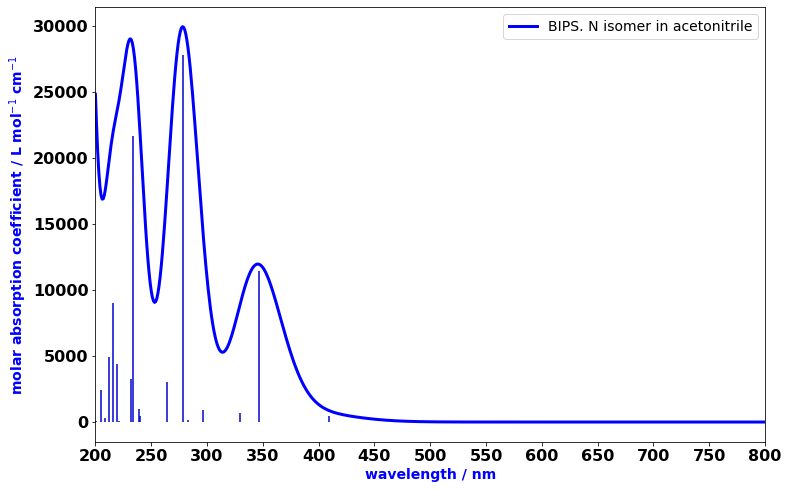

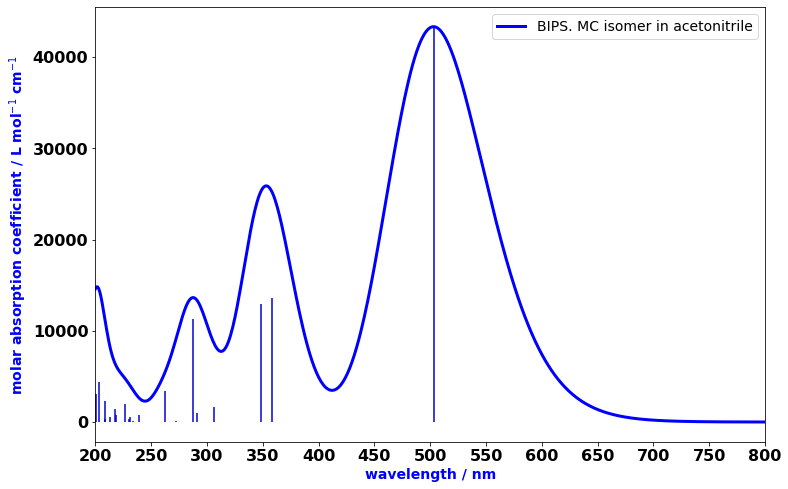

In [53]:
istateN,stateN,wavelN,feN,SSqN = np.genfromtxt("./BIPS/TDDFT/N-MeCN-TDDFT-LBS_Te_fe.csv",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
istateMC,stateMC,wavelMC,feMC,SSqMC = np.genfromtxt("./BIPS/TDDFT/MC-MeCN-TDDFT-LBS_Te_fe.csv",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)

wavel = np.arange(200,801,1)

sumIntN = sumStatesWithGf(wavel,wavelN,feN,sigmanm)
plotTDDFTSpectrum(wavel,sumIntN,wavelN,feN,sigmanm,"BIPS. N isomer in acetonitrile",200,800)
sumIntMC = sumStatesWithGf(wavel,wavelMC,feMC,sigmanm)
plotTDDFTSpectrum(wavel,sumIntMC,wavelMC,feMC,sigmanm,"BIPS. MC isomer in acetonitrile",200,800)

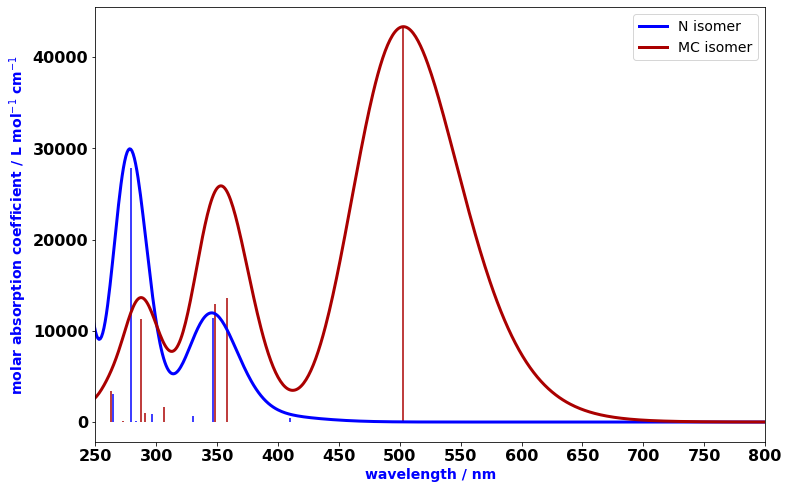

In [54]:
plt.figure(figsize=(12,8))
for i in range(len(wavelN)):
    plt.vlines(x = wavelN[i], ymin = 0, ymax = epsiG(wavelN[i],wavelN[i],feN[i],sigmanm), colors = '#0000ff')
for i in range(len(wavelMC)):
    plt.vlines(x = wavelMC[i], ymin = 0, ymax = epsiG(wavelMC[i],wavelMC[i],feMC[i],sigmanm), colors = '#aa0000')
plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='blue')
plt.ylabel('molar absorption coefficient / L mol$^{-1}$ cm$^{-1}$',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
plt.plot(wavel,sumIntN,linewidth=3,linestyle='-',color="#0000ff",label="N isomer")
plt.plot(wavel,sumIntMC,linewidth=3,linestyle='-',color="#aa0000",label="MC isomer")
plt.xlim(250,800)
plt.legend(fontsize=14)
import matplotlib.ticker as ticker
ax = plt.gca() # this is a way to deefined advanced plot options
ax.xaxis.set_major_locator(ticker.MultipleLocator(50)) # sets a tick for every integer multiple of the base (here 250) within the view interval
plt.savefig('./VUV-BIPS-MeCN.png',dpi=300,transparent=True)
plt.show()

In [55]:
peaksNI, peaksNH = FindPeaks(sumIntN,10)
print(f"{color.BOLD}6-NO2-BIPS, N isomer. TDDFT{color.OFF}")
for i in range(len(peaksNI)):
    print(f"peak {i:3}. {wavel[peaksNI[i]]:4} nm. epsilon = {peaksNH[i]:.1f}")

peaksMCI, peaksMCH = FindPeaks(sumIntMC,10)
print(f"{color.BOLD}6-NO2-BIPS, MC isomer. TDDFT{color.OFF}")
for i in range(len(peaksMCI)):
    print(f"peak {i:3}. {wavel[peaksMCI[i]]:4} nm. epsilon = {peaksMCH[i]:.1f}")

6-NO2-BIPS, N isomer. TDDFT
peak   0.  231 nm. epsilon = 29033.3
peak   1.  278 nm. epsilon = 29952.1
peak   2.  345 nm. epsilon = 11964.4
6-NO2-BIPS, MC isomer. TDDFT
peak   0.  201 nm. epsilon = 14821.3
peak   1.  288 nm. epsilon = 13638.6
peak   2.  353 nm. epsilon = 25892.6
peak   3.  503 nm. epsilon = 43340.9


## Experimental data: BIPS after irradiation

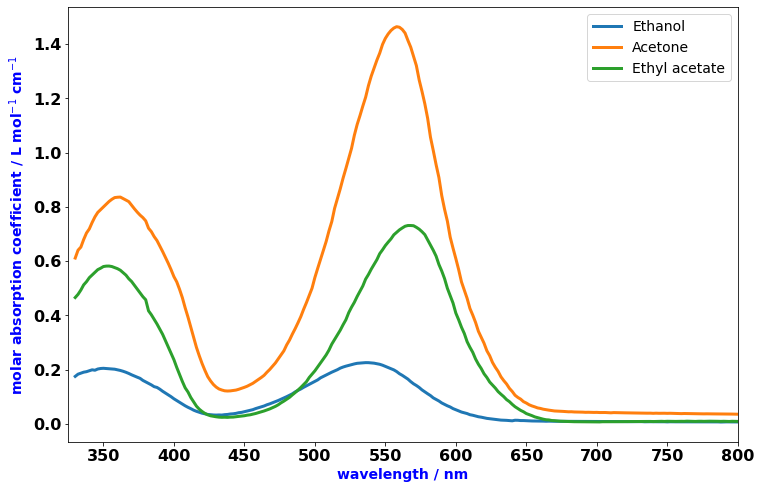

In [56]:
wavelEtOHexp,AbsEtOHexp = np.genfromtxt("./BIPS/Exp/ExpAbsSpectrumEtOH.csv",skip_header=1,unpack=True,delimiter=";")
wavelEtOHexp *= 1e9
wavelAcexp,AbsAcexp = np.genfromtxt("./BIPS/Exp/ExpAbsSpectrumAc.csv",skip_header=1,unpack=True,delimiter=";")
wavelAcexp *= 1e9
wavelEtOAcexp,AbsEtOAcexp = np.genfromtxt("./BIPS/Exp/ExpAbsSpectrumEtOAc.csv",skip_header=1,unpack=True,delimiter=";")
wavelEtOAcexp *= 1e9
plt.figure(figsize=(12,8))
plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='blue')
plt.ylabel('molar absorption coefficient / L mol$^{-1}$ cm$^{-1}$',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
plt.plot(wavelEtOHexp,AbsEtOHexp,linewidth=3,linestyle='-',label="Ethanol")
plt.plot(wavelAcexp,AbsAcexp,linewidth=3,linestyle='-',label="Acetone")
plt.plot(wavelEtOAcexp,AbsEtOAcexp,linewidth=3,linestyle='-',label="Ethyl acetate")
plt.xlim(325,800)
plt.legend(fontsize=14)
import matplotlib.ticker as ticker
ax = plt.gca() # this is a way to deefined advanced plot options
ax.xaxis.set_major_locator(ticker.MultipleLocator(50)) # sets a tick for every integer multiple of the base (here 250) within the view interval
plt.show()

In [57]:
from scipy.signal import find_peaks

peaksIEtOHexp, peaksHEtOHexp = FindPeaks(AbsEtOHexp,0.1)
print(f"{color.BOLD}6-NO2-BIPS in Ethanol{color.OFF}")
for i in range(len(peaksIEtOHexp)):
    print(f"peak {i:3}. {wavelEtOHexp[peaksIEtOHexp[i]]:4} nm. Abs = {peaksHEtOHexp[i]:.2f}")

peaksIAcexp, peaksHAcexp = FindPeaks(AbsAcexp,0.1)
print(f"{color.BOLD}6-NO2-BIPS in Acetone{color.OFF}")
for i in range(len(peaksIAcexp)):
    print(f"peak {i:3}. {wavelAcexp[peaksIAcexp[i]]:4} nm. Abs = {peaksHAcexp[i]:.2f}")
    
peaksIEtOAcexp, peaksHEtOAcexp = FindPeaks(AbsEtOAcexp,0.1)
print(f"{color.BOLD}6-NO2-BIPS in Ethyl acetate{color.OFF}")
for i in range(len(peaksIEtOAcexp)):
    print(f"peak {i:3}. {wavelEtOAcexp[peaksIEtOAcexp[i]]:4} nm. Abs = {peaksHEtOAcexp[i]:.2f}")

shiftExpEtOAc_AcA = -wavelEtOAcexp[peaksIEtOAcexp[0]]+wavelEtOAcexp[peaksIAcexp[0]]
shiftExpEtOAc_AcB = -wavelEtOAcexp[peaksIEtOAcexp[1]]+wavelEtOAcexp[peaksIAcexp[1]]

shiftExpEtOAc_EtOHA = -wavelEtOAcexp[peaksIEtOAcexp[0]]+wavelEtOAcexp[peaksIEtOHexp[1]]
shiftExpEtOAc_EtOHB = -wavelEtOAcexp[peaksIEtOAcexp[1]]+wavelEtOAcexp[peaksIEtOHexp[2]]


shiftExpAc_EtOHA = -wavelEtOAcexp[peaksIAcexp[0]]+wavelEtOAcexp[peaksIEtOHexp[1]]
shiftExpAc_EtOHB = -wavelEtOAcexp[peaksIAcexp[1]]+wavelEtOAcexp[peaksIEtOHexp[2]]

print(f"{color.BOLD}shifts exp Ac/EtOAc{color.OFF}")
print("peak A ",shiftExpEtOAc_AcA)
print("peak B ",shiftExpEtOAc_AcB)
print(f"{color.BOLD}shifts exp EtOH/EtOAc{color.OFF}")
print("peak A ",shiftExpEtOAc_EtOHA)
print("peak B ",shiftExpEtOAc_EtOHB)
print(f"{color.BOLD}shifts exp EtOH/Ac{color.OFF}")
print("peak A ",shiftExpAc_EtOHA)
print("peak B ",shiftExpAc_EtOHB)

6-NO2-BIPS in Ethanol
peak   0. 342.0 nm. Abs = 0.20
peak   1. 350.0 nm. Abs = 0.20
peak   2. 536.0 nm. Abs = 0.23
6-NO2-BIPS in Acetone
peak   0. 362.0 nm. Abs = 0.84
peak   1. 558.0 nm. Abs = 1.46
6-NO2-BIPS in Ethyl acetate
peak   0. 354.0 nm. Abs = 0.58
peak   1. 566.0 nm. Abs = 0.73
shifts exp Ac/EtOAc
peak A  8.0
peak B  -8.0
shifts exp EtOH/EtOAc
peak A  -4.0
peak B  -30.0
shifts exp EtOH/Ac
peak A  -12.0
peak B  -22.0


## MD calculations

Dyna


MD step selection? 10


42 atoms
143 coordinates saved between 0.0 and 0.71 ps


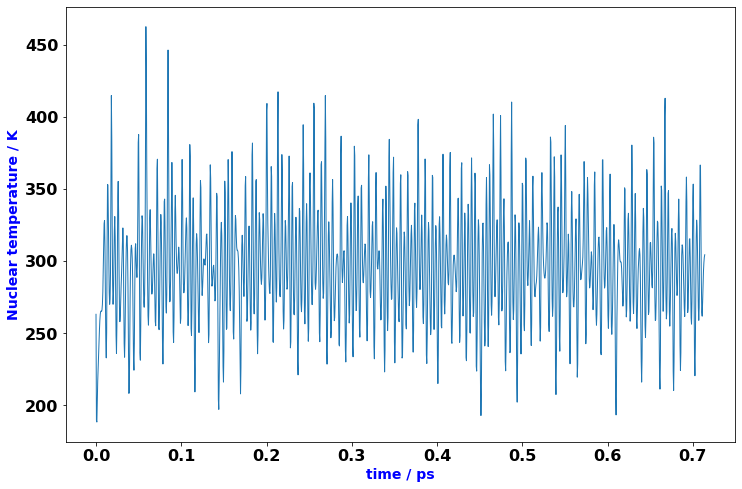

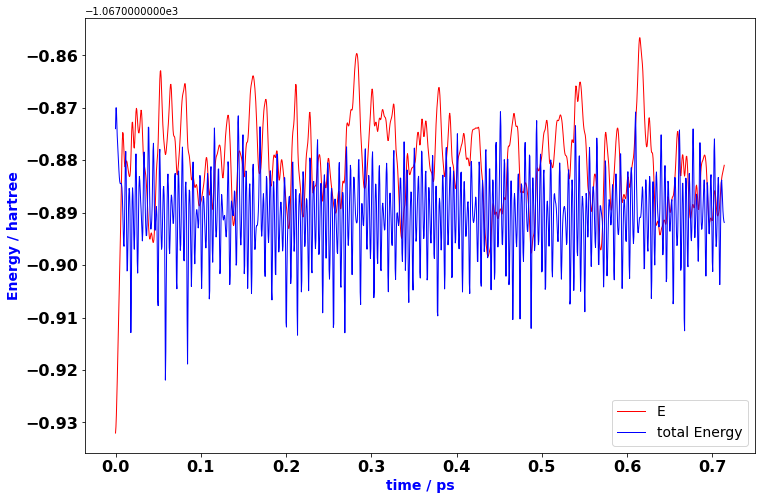

In [113]:
import sys
import scipy.constants as sc
import numpy as np
import matplotlib.pyplot as plt

#jupyter notebook
path = "./BIPS/MD/"
nameMDf="Dyna.data"

# interactive script
# path=""
# if (len(sys.argv) == 1):
#     print("please give a file name")
#     exit()
# print(f"{sys.argv[0]} in action")
# nameMDf = sys.argv[1]

###########
prefix=nameMDf.split(".")[0]
print(prefix)
nameMDf = path + nameMDf
nameETf = path + prefix + "_E_T.csv"
namexyzf = path + prefix +".xyz"

Eh = sc.e**2/(4*np.pi*sc.epsilon_0*sc.value('Bohr radius')) #hartree to J
h2kcal = Eh*1e-3*sc.N_A/4.184

saveCoord_everyNstep = input("MD step selection?")
saveCoord_everyNstep = int(saveCoord_everyNstep)

fMD = open(nameMDf, 'r')
fET = open(nameETf,'w')
fxyz = open(namexyzf,'w')
MDline = fMD.readline() #dummy line
MDline = fMD.readline()
nat = int(MDline.split("=")[1])
deglib=3*nat-6
print(f"{nat} atoms")
fET.write(f"time/fs \t energy/h \t kin energy/h \t thermostat/h \t SumE/h \t T/K \n")

timeTab=[]
NucTempTab=[]
ETab=[]
ETotTab=[]

nxyz = 0

while True:
    blankline = fMD.readline()
    MDline = fMD.readline()
    if not MDline:
        break
    iMD,e,time,E,K,therm = MDline.split()
    iMD=int(iMD)
    Kf=float(K)*Eh #converted in J
    Ef=float(E)
    thermf=float(therm)
    timef=float(time)
    NucTemp = 2*Kf/(sc.k*deglib)
    ETot=Ef+Kf+thermf
    fET.write(f"{time}\t{E}\t{K}\t{therm}\t{ETot}\t{NucTemp}\n")

    timeTab.append(timef*1e-3)
    NucTempTab.append(NucTemp)
    ETab.append(Ef)
    ETotTab.append(ETot)

    if (iMD == 0):
        ETot0 = Ef+Kf+thermf
        E0 = Ef
    Symb=[]
    Coord=[]
    for i in range(nat):
        ia,symb,x,y,z,vx,vy,vz,ax,ay,az = fMD.readline().split()
        Symb.append(symb)
        Coord.append([symb,x,y,z])

    if (iMD%saveCoord_everyNstep == 0):
        nxyz += 1
        if (iMD == 0): time0=timef
        timelast=time
        DETot = (Ef+Kf+thermf - ETot0)*h2kcal
        DE = (Ef - E0)*h2kcal
        title = f"{iMD:07d} #  " + f"\t{timef*1e-3:.4f} ps  " + f"\t{NucTemp:.1f} K   " + f"\t{DE:8.1f} kcal/mol" + f"\t{DETot:8.1f} kcal/mol"
        fxyz.write(f"{nat}\n")
        fxyz.write(title+"\n")
        for i in range(nat):
            fxyz.write("\t".join(Coord[i])+"\n")

fMD.close()
fET.close()
fxyz.close()

print(f"{nxyz} coordinates saved between {float(time0)*1e-3} and {float(timelast)*1e-3} ps")

plt.figure(1,figsize=(12,8))
plt.xlabel('time / ps',size=14,fontweight='bold',color='blue')
plt.ylabel('Nuclear temperature / K',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
plt.plot(timeTab,NucTempTab,linewidth=1,linestyle='-')
#plt.legend(fontsize=14)

plt.figure(2,figsize=(12,8))
plt.xlabel('time / ps',size=14,fontweight='bold',color='blue')
plt.ylabel('Energy / hartree',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
plt.plot(timeTab,ETab,linewidth=1,linestyle='-',color='red',label='E')
plt.plot(timeTab,ETotTab,linewidth=1,linestyle='-',color='blue',label='total Energy')
plt.legend(fontsize=14)
plt.show()

In [108]:
import sys
import scipy.constants as sc
import numpy as np
import matplotlib.pyplot as plt

#from a jupyter notebook
path = "./BIPS/MD/"
nameMDf="Dyna.data"

# interactive script
# path=""
# print(f"{sys.argv[0]} in action")
# if (len(sys.argv) == 1):
#     print("please give a file name")
#     exit()
# print("xyz rdyn file, from Geraldyn: ",sys.argv[1])
# nameMDf = sys.argv[1]

header = "headerG16.com"
print()
print(f"The Gaussian16 header is expected to be available in the {header} file")
print(f"!! no trailing blank line in this file")
print(f"But do not forget the %chk line")
print()
###########
prefix=nameMDf.split(".")[0]
print(prefix)
nameMDf = path + nameMDf
namexyzf = path + prefix +".xyz"
namecom = path + prefix + "_G16.com"
nameheader = path + header


saveCoord_aftert = input("Skip coordinates below XX ps")
saveCoord_aftert = float(saveCoord_aftert)
fxyz = open(namexyzf,'r')
fcom = open(namecom,'w')
fh = open(nameheader,'r')


emptyline = "\n"

nxyz = 0

while True:
    lineNAtoms = fxyz.readline() #number of atoms, hopefully. Or eof
    if not lineNAtoms:
        break
    nat = int(lineNAtoms)
    titleline = fxyz.readline() #title line
    iMD,dummy,timef,dummy,Tnuc,dummy,De,dummy,Detot,dummy = titleline.split()
    timef = float(timef)
    # if (timef < saveCoord_aftert):
    #     print(f"{timef} < {saveCoord_aftert} -> not kept")
    # else:
    #     print(f"{timef} > {saveCoord_aftert} -> kept")
    if (timef >= saveCoord_aftert):
        nxyz += 1
        fcom.write(fh.read())
        fcom.write(f"\n")
        fcom.write(f"{emptyline}")
        fh.seek(0)
        titleline = titleline.replace('\t',' ')
        fcom.write(titleline)
        fcom.write(f"{emptyline}")
        fcom.write(f"0 1\n")
    for i in range(nat):
        line = fxyz.readline()
        if (timef >= saveCoord_aftert):
            line = line.replace('\t','    ')
            fcom.write(line)
    if (timef >= saveCoord_aftert):
        fcom.write(emptyline)
        fcom.write(f"##Link1##\n")

print(f"{nxyz} Gaussian calculations will be done. Are you sure?")
fxyz.close()
fcom.close()
fh.close()


The Gaussian16 header is expected to be available in the headerG16.com file
!! no trailing blank line in this file
But do not forget the %chk line
Dyna


Skip coordinates below XX ps 0.2


102 Gaussian calculations will be done. Are you sure?


## TDDFT results

In [59]:
#gaussian half-width
sigma = 0.3 #eV 0.4 eV is the default value in GaussView
eV2nm = (sc.h * sc.c)*1e9 / (sc.e)
sigmanm = eV2nm/sigma
print("sigma = ", sigma ,"eV ->",sigmanm," nm (sigmanm)")

# simulation range
wavel = np.arange(200,801,1)

sigma =  0.3 eV -> 4132.806614440009  nm (sigmanm)


### Gas-phase

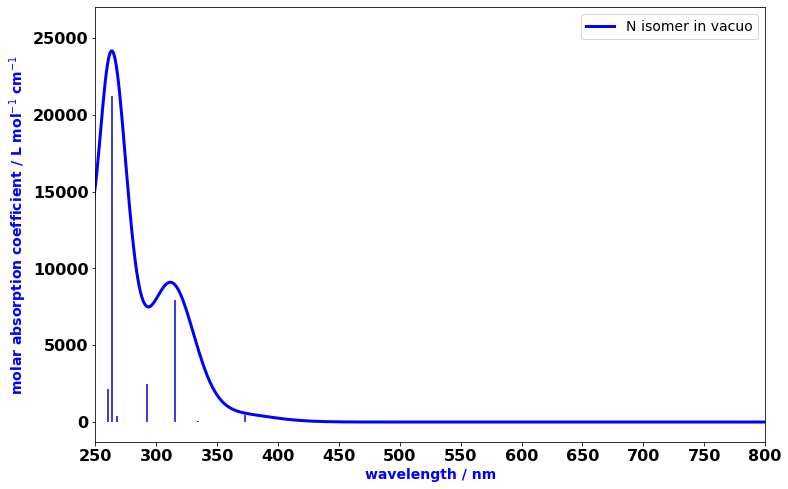

6-NO2-BIPS, N isomer in ethanol. TDDFT
peak   0.  228 nm. epsilon = 25724.3 L mol-1 cm-1
peak   1.  263 nm. epsilon = 24147.6 L mol-1 cm-1
peak   2.  311 nm. epsilon = 9091.4 L mol-1 cm-1


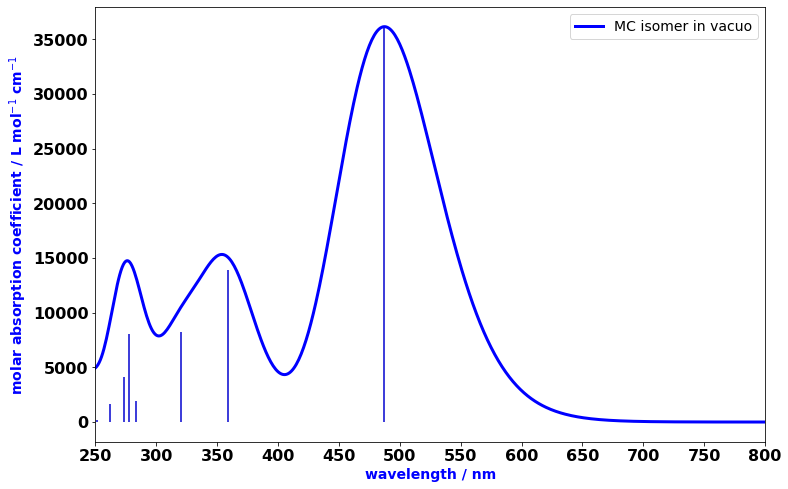

6-NO2-BIPS, MC isomer in ethanol. TDDFT
peak   0.  215 nm. epsilon = 6715.8 L mol-1 cm-1
peak   1.  244 nm. epsilon = 4783.8 L mol-1 cm-1
peak   2.  276 nm. epsilon = 14762.2 L mol-1 cm-1
peak   3.  354 nm. epsilon = 15333.1 L mol-1 cm-1
peak   4.  487 nm. epsilon = 36169.4 L mol-1 cm-1


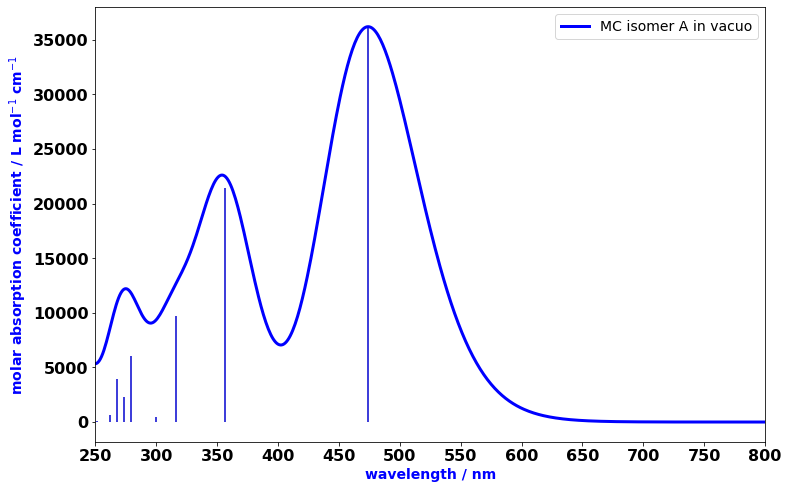

6-NO2-BIPS, MC isomer in ethanol. TDDFT
peak   0.  206 nm. epsilon = 8175.4 L mol-1 cm-1
peak   1.  239 nm. epsilon = 6055.6 L mol-1 cm-1
peak   2.  275 nm. epsilon = 12211.8 L mol-1 cm-1
peak   3.  354 nm. epsilon = 22616.9 L mol-1 cm-1
peak   4.  474 nm. epsilon = 36203.9 L mol-1 cm-1


In [60]:
istateNvac,stateNvac,wavelNvac,feNvac,SSqNvac = np.genfromtxt("./BIPS/TDDFT/N-vac-TDDFT-LBS_Te_fe.csv",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
sumIntNvac = sumStatesWithGf(wavel,wavelNvac,feNvac,sigmanm)
plotTDDFTSpectrum(wavel,sumIntNvac,wavelNvac,feNvac,sigmanm,"N isomer in vacuo")
peaksINvac, peaksHNvac = FindPeaks(sumIntNvac,10)
print(f"{color.BOLD}6-NO2-BIPS, N isomer in ethanol. TDDFT{color.OFF}")
for i in range(len(peaksINvac)):
    print(f"peak {i:3}. {wavel[peaksINvac[i]]:4} nm. epsilon = {peaksHNvac[i]:.1f} L mol-1 cm-1")

istateMCvac,stateMCvac,wavelMCvac,feMCvac,SSqMCvac = np.genfromtxt("./BIPS/TDDFT/MC-vac-TDDFT-LBS_Te_fe.csv",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
sumIntMCvac = sumStatesWithGf(wavel,wavelMCvac,feMCvac,sigmanm)
plotTDDFTSpectrum(wavel,sumIntMCvac,wavelMCvac,feMCvac,sigmanm,"MC isomer in vacuo")
peaksIMCvac, peaksHMCvac = FindPeaks(sumIntMCvac,10)
print(f"{color.BOLD}6-NO2-BIPS, MC isomer in ethanol. TDDFT{color.OFF}")
for i in range(len(peaksIMCvac)):
    print(f"peak {i:3}. {wavel[peaksIMCvac[i]]:4} nm. epsilon = {peaksHMCvac[i]:.1f} L mol-1 cm-1")
    
istateMCAvac,stateMCAvac,wavelMCAvac,feMCAvac,SSqMCAvac = np.genfromtxt("./BIPS/TDDFT/MCvac-NopenA-TDDFT-LBS_ExcStab.dat",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
sumIntMCAvac = sumStatesWithGf(wavel,wavelMCAvac,feMCAvac,sigmanm)
plotTDDFTSpectrum(wavel,sumIntMCAvac,wavelMCAvac,feMCAvac,sigmanm,"MC isomer A in vacuo")
peaksIMCAvac, peaksHMCAvac = FindPeaks(sumIntMCAvac,10)
print(f"{color.BOLD}6-NO2-BIPS, MC isomer in ethanol. TDDFT{color.OFF}")
for i in range(len(peaksIMCAvac)):
    print(f"peak {i:3}. {wavel[peaksIMCAvac[i]]:4} nm. epsilon = {peaksHMCAvac[i]:.1f} L mol-1 cm-1")

### Ethanol

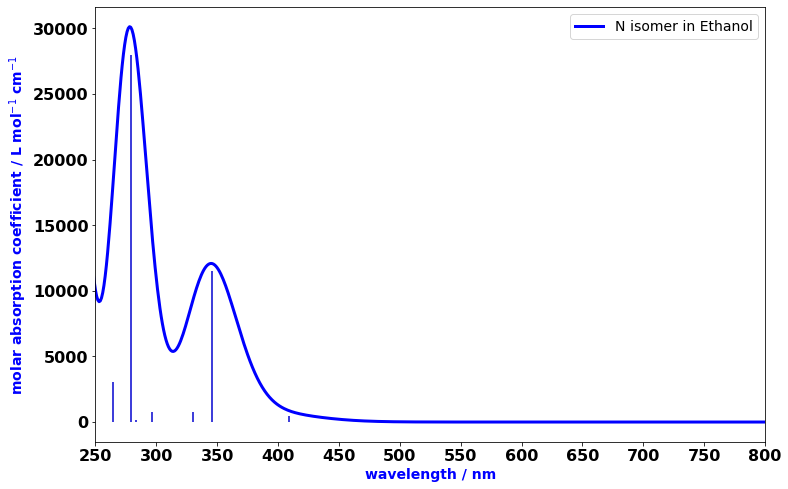

6-NO2-BIPS, N isomer in ethanol. TDDFT
peak   0.  231 nm. epsilon = 29295.7 L mol-1 cm-1
peak   1.  278 nm. epsilon = 30134.6 L mol-1 cm-1
peak   2.  345 nm. epsilon = 12088.8 L mol-1 cm-1


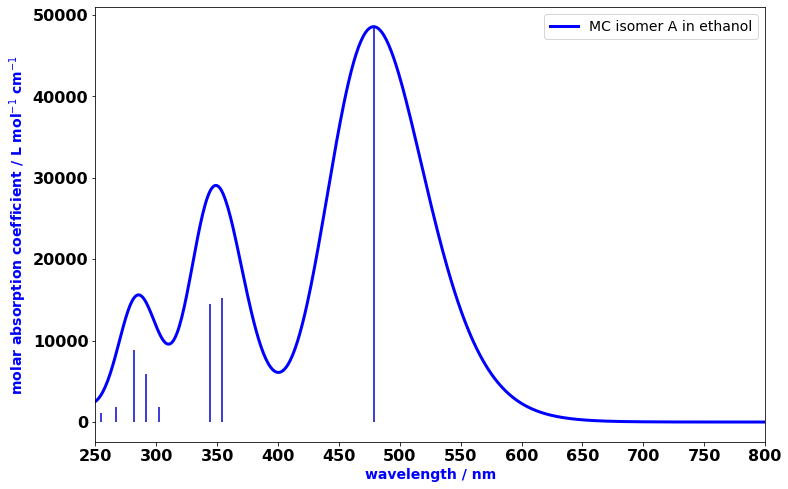

6-NO2-BIPS, MC isomer A in ethanol. TDDFT
peak   0.  203 nm. epsilon = 11970.8 L mol-1 cm-1
peak   1.  285 nm. epsilon = 15613.2 L mol-1 cm-1
peak   2.  349 nm. epsilon = 29065.4 L mol-1 cm-1
peak   3.  479 nm. epsilon = 48553.8 L mol-1 cm-1


In [61]:
istateNEtOH,stateNEtOH,wavelNEtOH,feNEtOH,SSqNEtOH = np.genfromtxt("./BIPS/TDDFT/N-EtOH-TDDFT-LBS_Te_fe.csv",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
sumIntNEtOH = sumStatesWithGf(wavel,wavelNEtOH,feNEtOH,sigmanm)
plotTDDFTSpectrum(wavel,sumIntNEtOH,wavelNEtOH,feNEtOH,sigmanm,"N isomer in Ethanol")
peaksINEtOH, peaksHNEtOH = FindPeaks(sumIntNEtOH,10)
print(f"{color.BOLD}6-NO2-BIPS, N isomer in ethanol. TDDFT{color.OFF}")
for i in range(len(peaksINEtOH)):
    print(f"peak {i:3}. {wavel[peaksINEtOH[i]]:4} nm. epsilon = {peaksHNEtOH[i]:.1f} L mol-1 cm-1")

istateMCEtOH,stateMCEtOH,wavelMCEtOH,feMCEtOH,SSqMCEtOH = np.genfromtxt("./BIPS/TDDFT/MCEtOH-NopenA-TDDFT-LBS_ExcStab.dat",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
sumIntMCEtOH = sumStatesWithGf(wavel,wavelMCEtOH,feMCEtOH,sigmanm)
plotTDDFTSpectrum(wavel,sumIntMCEtOH,wavelMCEtOH,feMCEtOH,sigmanm,"MC isomer A in ethanol")
peaksIMCEtOH, peaksHMCEtOH = FindPeaks(sumIntMCEtOH,10)
print(f"{color.BOLD}6-NO2-BIPS, MC isomer A in ethanol. TDDFT{color.OFF}")
for i in range(len(peaksIMCEtOH)):
    print(f"peak {i:3}. {wavel[peaksIMCEtOH[i]]:4} nm. epsilon = {peaksHMCEtOH[i]:.1f} L mol-1 cm-1")

### Ethyl acetate

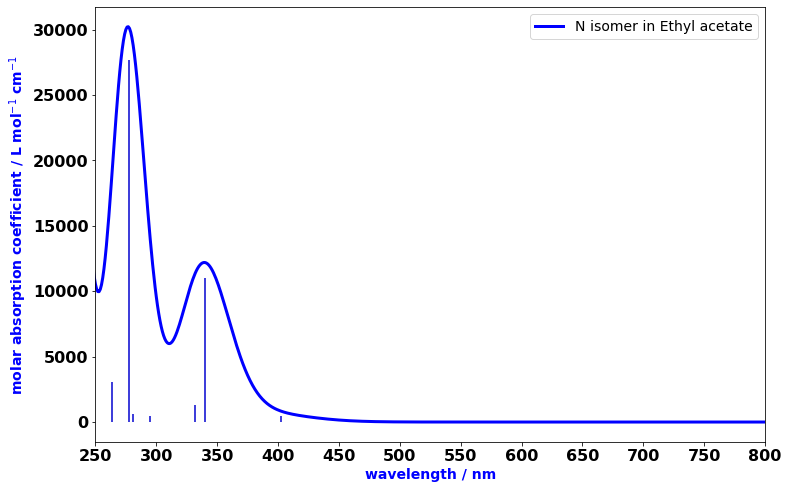

6-NO2-BIPS, N isomer in Ethyl acetate. TDDFT
peak   0.  231 nm. epsilon = 29884.9 L mol-1 cm-1
peak   1.  277 nm. epsilon = 30218.2 L mol-1 cm-1
peak   2.  339 nm. epsilon = 12193.6 L mol-1 cm-1


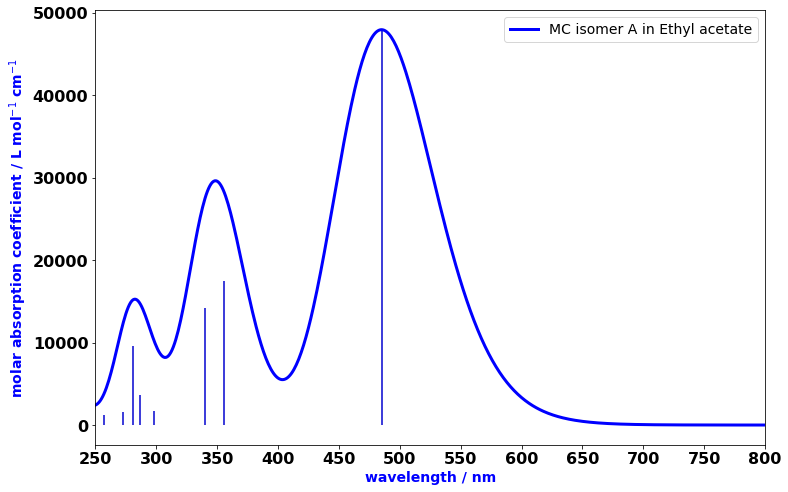

6-NO2-BIPS, MC isomer A in Ethyl acetate. TDDFT
peak   0.  205 nm. epsilon = 11350.7 L mol-1 cm-1
peak   1.  282 nm. epsilon = 15256.0 L mol-1 cm-1
peak   2.  349 nm. epsilon = 29615.8 L mol-1 cm-1
peak   3.  485 nm. epsilon = 47936.1 L mol-1 cm-1


In [62]:
istateNEtOAc,stateNEtOAc,wavelNEtOAc,feNEtOAc,SSqNEtOAc = np.genfromtxt("./BIPS/TDDFT/N-EtOAc-TDDFT-LBS_Te_fe.csv",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
sumIntNEtOAc = sumStatesWithGf(wavel,wavelNEtOAc,feNEtOAc,sigmanm)
plotTDDFTSpectrum(wavel,sumIntNEtOAc,wavelNEtOAc,feNEtOAc,sigmanm,"N isomer in Ethyl acetate")
peaksINEtOAc, peaksHNEtOAc = FindPeaks(sumIntNEtOAc,10)
print(f"{color.BOLD}6-NO2-BIPS, N isomer in Ethyl acetate. TDDFT{color.OFF}")
for i in range(len(peaksINEtOAc)):
    print(f"peak {i:3}. {wavel[peaksINEtOAc[i]]:4} nm. epsilon = {peaksHNEtOAc[i]:.1f} L mol-1 cm-1")
    
istateMCEtOAc,stateMCEtOAc,wavelMCEtOAc,feMCEtOAc,SSqMCEtOAc = np.genfromtxt("./BIPS/TDDFT/MCEtOAc-NopenA-TDDFT-LBS_ExcStab.dat",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
sumIntMCEtOAc = sumStatesWithGf(wavel,wavelMCEtOAc,feMCEtOAc,sigmanm)
plotTDDFTSpectrum(wavel,sumIntMCEtOAc,wavelMCEtOAc,feMCEtOAc,sigmanm,"MC isomer A in Ethyl acetate")
peaksIMCEtOAc, peaksHMCEtOAc = FindPeaks(sumIntMCEtOAc,10)
print(f"{color.BOLD}6-NO2-BIPS, MC isomer A in Ethyl acetate. TDDFT{color.OFF}")
for i in range(len(peaksIMCEtOAc)):
    print(f"peak {i:3}. {wavel[peaksIMCEtOAc[i]]:4} nm. epsilon = {peaksHMCEtOAc[i]:.1f} L mol-1 cm-1")

### Acetone

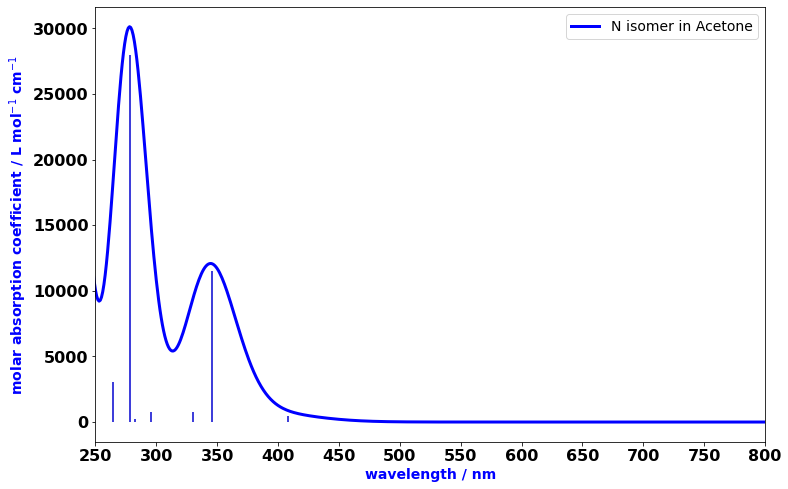

6-NO2-BIPS, N isomer in Acetone. TDDFT
peak   0.  231 nm. epsilon = 29301.0 L mol-1 cm-1
peak   1.  278 nm. epsilon = 30119.0 L mol-1 cm-1
peak   2.  345 nm. epsilon = 12077.1 L mol-1 cm-1


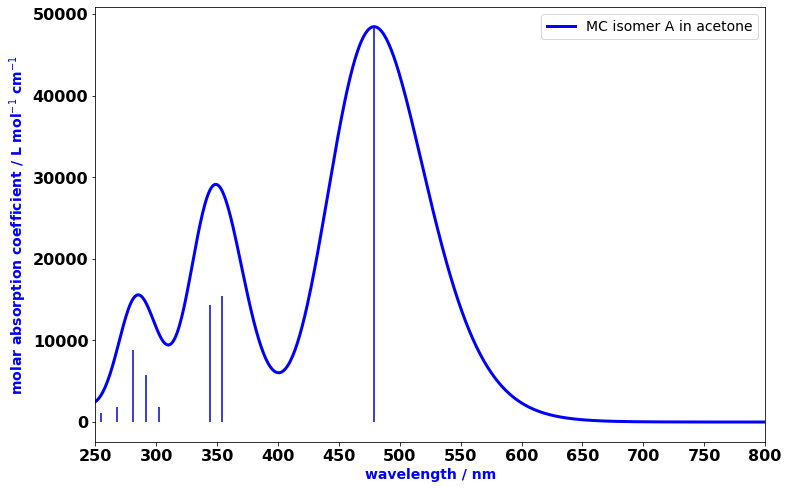

6-NO2-BIPS, MC isomer A in acetone. TDDFT
peak   0.  203 nm. epsilon = 11788.6 L mol-1 cm-1
peak   1.  285 nm. epsilon = 15587.1 L mol-1 cm-1
peak   2.  349 nm. epsilon = 29133.3 L mol-1 cm-1
peak   3.  479 nm. epsilon = 48454.6 L mol-1 cm-1


In [63]:
istateNAc,stateNAc,wavelNAc,feNAc,SSqNAc = np.genfromtxt("./BIPS/TDDFT/N-Ac-TDDFT-LBS_Te_fe.csv",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
sumIntNAc = sumStatesWithGf(wavel,wavelNAc,feNAc,sigmanm)
plotTDDFTSpectrum(wavel,sumIntNAc,wavelNAc,feNAc,sigmanm,"N isomer in Acetone")
peaksINAc, peaksHNAc = FindPeaks(sumIntNAc,10)
print(f"{color.BOLD}6-NO2-BIPS, N isomer in Acetone. TDDFT{color.OFF}")
for i in range(len(peaksINAc)):
    print(f"peak {i:3}. {wavel[peaksINAc[i]]:4} nm. epsilon = {peaksHNAc[i]:.1f} L mol-1 cm-1")

istateMCAc,stateMCAc,wavelMCAc,feMCAc,SSqMCAc = np.genfromtxt("./BIPS/TDDFT/MCAc-NopenA-TDDFT-LBS_ExcStab.dat",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
sumIntMCAc = sumStatesWithGf(wavel,wavelMCAc,feMCAc,sigmanm)
plotTDDFTSpectrum(wavel,sumIntMCAc,wavelMCAc,feMCAc,sigmanm,"MC isomer A in acetone")
peaksIMCAc, peaksHMCAc = FindPeaks(sumIntMCAc,10)
print(f"{color.BOLD}6-NO2-BIPS, MC isomer A in acetone. TDDFT{color.OFF}")
for i in range(len(peaksIMCAc)):
    print(f"peak {i:3}. {wavel[peaksIMCAc[i]]:4} nm. epsilon = {peaksHMCAc[i]:.1f} L mol-1 cm-1")

## TDDFT calculations vs. experiments

### Spectra

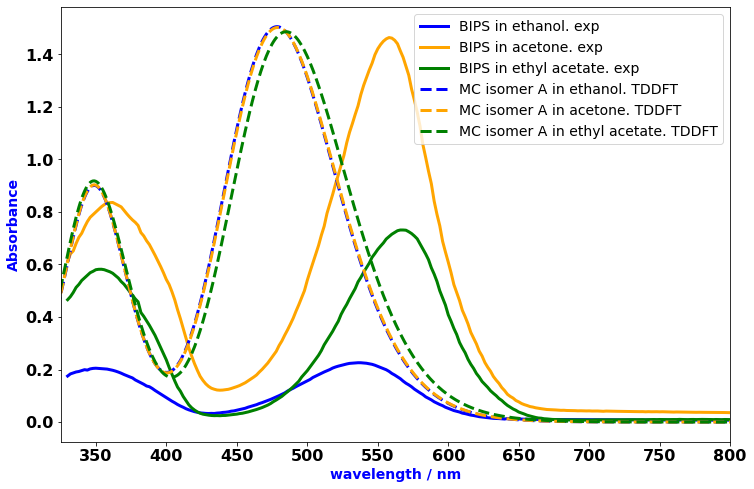

In [64]:
plt.figure(figsize=(12,8))
plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='blue')
plt.ylabel('Absorbance',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
plt.xlim(325,800)

#experiments
plt.plot(wavelEtOHexp,AbsEtOHexp,linewidth=3,linestyle='-',color="#0000ff",label="BIPS in ethanol. exp")
plt.plot(wavelAcexp,AbsAcexp,linewidth=3,linestyle='-',color="orange",label="BIPS in acetone. exp")
plt.plot(wavelEtOAcexp,AbsEtOAcexp,linewidth=3,linestyle='-',color="green",label="BIPS in ethyl acetate. exp")

#TDDFT
AbsMCEtOH = Absorbance(sumIntMCEtOH,1,3.1e-5)
plt.plot(wavel,AbsMCEtOH,linewidth=3,linestyle='--',color="#0000ff",label="MC isomer A in ethanol. TDDFT")
AbsMCAc = Absorbance(sumIntMCAc,1,3.1e-5)
plt.plot(wavel,AbsMCAc,linewidth=3,linestyle='--',color="orange",label="MC isomer A in acetone. TDDFT")
AbsMCEtOAc = Absorbance(sumIntMCEtOAc,1,3.1e-5)
plt.plot(wavel,AbsMCEtOAc,linewidth=3,linestyle='--',color="green",label="MC isomer A in ethyl acetate. TDDFT")

plt.legend(fontsize=14)
import matplotlib.ticker as ticker
ax = plt.gca() # this is a way to deefined advanced plot options
ax.xaxis.set_major_locator(ticker.MultipleLocator(50)) # sets a tick for every integer multiple of the base (here 250) within the view interval
#plt.savefig('./VUV-BIPS.png',dpi=300,transparent=True)
plt.show()

### Shifts

In [65]:
print(f"{color.BOLD}shifts exp Ac/EtOAc{color.OFF}")
print("peak A ",shiftExpEtOAc_AcA)
print("peak B ",shiftExpEtOAc_AcB)
print(f"{color.BOLD}shifts exp EtOH/EtOAc{color.OFF}")
print("peak A ",shiftExpEtOAc_EtOHA)
print("peak B ",shiftExpEtOAc_EtOHB)
print(f"{color.BOLD}shifts exp EtOH/Ac{color.OFF}")
print("peak A ",shiftExpAc_EtOHA)
print("peak B ",shiftExpAc_EtOHB)

shifts exp Ac/EtOAc
peak A  8.0
peak B  -8.0
shifts exp EtOH/EtOAc
peak A  -4.0
peak B  -30.0
shifts exp EtOH/Ac
peak A  -12.0
peak B  -22.0


In [66]:
shiftMC_DFTEtOAc_AcA = -wavel[peaksIMCEtOAc[2]]+wavel[peaksIMCAc[2]]
shiftMC_DFTEtOAc_AcB = -wavel[peaksIMCEtOAc[3]]+wavel[peaksIMCAc[3]]

shiftMC_DFTEtOAc_EtOHA = -wavel[peaksIMCEtOAc[2]]+wavel[peaksIMCEtOH[2]]
shiftMC_DFTEtOAc_EtOHB = -wavel[peaksIMCEtOAc[3]]+wavel[peaksIMCEtOH[3]]

shiftMC_DFTAc_EtOHA = -wavel[peaksIMCAc[2]]+wavel[peaksIMCEtOH[2]]
shiftMC_DFTAc_EtOHB = -wavel[peaksIMCAc[3]]+wavel[peaksIMCEtOH[3]]

print(f"{color.BOLD}shifts DFT MC Ac/EtOAc{color.OFF}")
print("peak A ",shiftMC_DFTEtOAc_AcA)
print("peak B ",shiftMC_DFTEtOAc_AcB)
print(f"{color.BOLD}shifts DFT MC EtOH/EtOAc{color.OFF}")
print("peak A ",shiftMC_DFTEtOAc_EtOHA)
print("peak B ",shiftMC_DFTEtOAc_EtOHB)
print(f"{color.BOLD}shifts DFT MC EtOH/Ac{color.OFF}")
print("peak A ",shiftMC_DFTAc_EtOHA)
print("peak B ",shiftMC_DFTAc_EtOHB)

shifts DFT MC Ac/EtOAc
peak A  0
peak B  -6
shifts DFT MC EtOH/EtOAc
peak A  0
peak B  -6
shifts DFT MC EtOH/Ac
peak A  0
peak B  0


## MC-A-BIPS models with various substituents. TDDFT calculations in ethanol

In [115]:
print(f"{color.BOLD}6-NO2-BIPS, MC isomer A in ethanol. TDDFT{color.OFF}")
m = Chem.MolFromSmiles('CN3/C(=C\C=c1cc(N(=O)=O)ccc1=O)C(C)(C)c2ccccc23')
print(m)
for i in range(len(peaksIMCEtOH)):
    print(f"peak {i:3}. {wavel[peaksIMCEtOH[i]]:4} nm. epsilon = {peaksHMCEtOH[i]:.1f} L mol-1 cm-1")

6-NO2-BIPS, MC isomer A in ethanol. TDDFT


NameError: name 'Chem' is not defined

In [68]:
# with NO2 and 3 explicit water molecules
istateMCEtOHx,stateMCEtOHx,wavelMCEtOHx,feMCEtOHx,SSqMCEtOHx = np.genfromtxt("./BIPS/TDDFT/MCEtOH-NopenA-3H2O-TDDFT-LBS_ExcStab.dat",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
sumIntMCEtOHx = sumStatesWithGf(wavel,wavelMCEtOHx,feMCEtOHx,sigmanm)
peaksIMCEtOHx, peaksHMCEtOHx = FindPeaks(sumIntMCEtOHx,10)
print(f"{color.BOLD}BIPS, MC isomer A in ethanol. woNO2. TDDFT{color.OFF}")
for i in range(len(peaksIMCEtOHx)):
    print(f"peak {i:3}. {wavel[peaksIMCEtOHx[i]]:4} nm. epsilon = {peaksHMCEtOHx[i]:.1f} L mol-1 cm-1")

BIPS, MC isomer A in ethanol. woNO2. TDDFT
peak   0.  224 nm. epsilon = 4834.9 L mol-1 cm-1
peak   1.  350 nm. epsilon = 30041.7 L mol-1 cm-1
peak   2.  456 nm. epsilon = 41437.5 L mol-1 cm-1


In [69]:
# without NO2
mwoNO2 = Chem.MolFromSmiles('CN3/C(=C\C=c1ccccc1=O)C(C)(C)c2ccccc23')
print(mwoNO2)
istateMCwoNO2EtOH,stateMCwoNO2EtOH,wavelMCwoNO2EtOH,feMCwoNO2EtOH,SSqMCwoNO2EtOH = np.genfromtxt("./BIPS/TDDFT/MCNwoNO2-NopenA-EtOH-TDDFT-LBS_ExcStab.dat",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
sumIntMCwoNO2EtOH = sumStatesWithGf(wavel,wavelMCwoNO2EtOH,feMCwoNO2EtOH,sigmanm)
peaksIMCwoNO2EtOH, peaksHMCwoNO2EtOH = FindPeaks(sumIntMCwoNO2EtOH,10)
print(f"{color.BOLD}BIPS, MC isomer A in ethanol. woNO2. TDDFT{color.OFF}")
for i in range(len(peaksIMCwoNO2EtOH)):
    print(f"peak {i:3}. {wavel[peaksIMCwoNO2EtOH[i]]:4} nm. epsilon = {peaksHMCwoNO2EtOH[i]:.1f} L mol-1 cm-1")

BIPS, MC isomer A in ethanol. woNO2. TDDFT
peak   0.  276 nm. epsilon = 6793.2 L mol-1 cm-1
peak   1.  348 nm. epsilon = 16271.6 L mol-1 cm-1
peak   2.  442 nm. epsilon = 45370.7 L mol-1 cm-1


In [70]:
# Nnaphta
mNnaphta = Chem.MolFromSmiles('CN4/C(=C\N=c1c(=O)ccc2ccccc12)C(C)(C)c3ccccc34')
print(mNnaphta)
istateMCNnaphtaEtOH,stateMCNnaphtaEtOH,wavelMCNnaphtaEtOH,feMCNnaphtaEtOH,SSqMCNnaphtaEtOH = np.genfromtxt("./BIPS/TDDFT/MCNnaphta-NopenA-EtOH-TDDFT-LBS_ExcStab.dat",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
sumIntMCNnaphtaEtOH = sumStatesWithGf(wavel,wavelMCNnaphtaEtOH,feMCNnaphtaEtOH,sigmanm)
peaksIMCNnaphtaEtOH, peaksHMCNnaphtaEtOH = FindPeaks(sumIntMCNnaphtaEtOH,10)
print(f"{color.BOLD}BIPS, MC isomer A in ethanol. N naphta. TDDFT{color.OFF}")
for i in range(len(peaksIMCNnaphtaEtOH)):
    print(f"peak {i:3}. {wavel[peaksIMCNnaphtaEtOH[i]]:4} nm. epsilon = {peaksHMCNnaphtaEtOH[i]:.1f} L mol-1 cm-1")

BIPS, MC isomer A in ethanol. N naphta. TDDFT
peak   0.  227 nm. epsilon = 40468.2 L mol-1 cm-1
peak   1.  266 nm. epsilon = 8442.5 L mol-1 cm-1
peak   2.  315 nm. epsilon = 7720.4 L mol-1 cm-1
peak   3.  387 nm. epsilon = 5098.3 L mol-1 cm-1
peak   4.  502 nm. epsilon = 49736.1 L mol-1 cm-1


In [71]:
# NbwoNO2
mNbwoNO2 = Chem.MolFromSmiles('CN3/C(=C\N=c1ccccc1=O)C(C)(C)c2ccccc23')
print(mNbwoNO2)
istateMCNbwoNO2EtOH,stateMCNbwoNO2EtOH,wavelMCNbwoNO2EtOH,feMCNbwoNO2EtOH,SSqMCNbwoNO2EtOH = np.genfromtxt("./BIPS/TDDFT/MCNbwoNO2-NopenA-EtOH-TDDFT-LBS_ExcStab.dat",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
sumIntMCNbwoNO2EtOH = sumStatesWithGf(wavel,wavelMCNbwoNO2EtOH,feMCNbwoNO2EtOH,sigmanm)
peaksIMCNbwoNO2EtOH, peaksHMCNbwoNO2EtOH = FindPeaks(sumIntMCNbwoNO2EtOH,10)
print(f"{color.BOLD}BIPS, MC isomer A in ethanol. Nb woNO2. TDDFT{color.OFF}")
for i in range(len(peaksIMCNbwoNO2EtOH)):
    print(f"peak {i:3}. {wavel[peaksIMCNbwoNO2EtOH[i]]:4} nm. epsilon = {peaksHMCNbwoNO2EtOH[i]:.1f} L mol-1 cm-1")

BIPS, MC isomer A in ethanol. Nb woNO2. TDDFT
peak   0.  289 nm. epsilon = 4832.2 L mol-1 cm-1
peak   1.  377 nm. epsilon = 20259.0 L mol-1 cm-1
peak   2.  511 nm. epsilon = 40148.4 L mol-1 cm-1


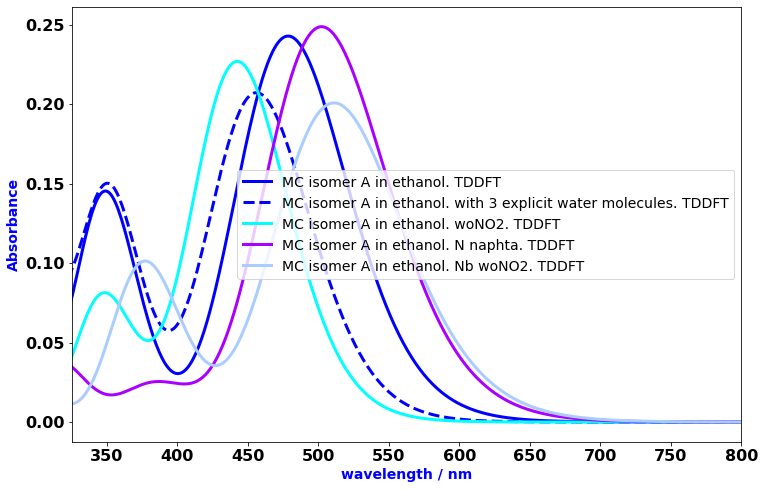

In [72]:
plt.figure(figsize=(12,8))
plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='blue')
plt.ylabel('Absorbance',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
plt.xlim(325,800)

#TDDFT
AbsMCEtOH = Absorbance(sumIntMCEtOH,1,5e-6)
plt.plot(wavel,AbsMCEtOH,linewidth=3,linestyle='-',color="#0000ff",label="MC isomer A in ethanol. TDDFT")
AbsMCEtOHx = Absorbance(sumIntMCEtOHx,1,5e-6)
plt.plot(wavel,AbsMCEtOHx,linewidth=3,linestyle='--',color="#0000ff",label="MC isomer A in ethanol. with 3 explicit water molecules. TDDFT")
AbsMCwoNO2EtOH = Absorbance(sumIntMCwoNO2EtOH,1,5e-6)
plt.plot(wavel,AbsMCwoNO2EtOH,linewidth=3,linestyle='-',color="#00ffff",label="MC isomer A in ethanol. woNO2. TDDFT")
AbsMCNnaphtaEtOH = Absorbance(sumIntMCNnaphtaEtOH,1,5e-6)
plt.plot(wavel,AbsMCNnaphtaEtOH,linewidth=3,linestyle='-',color="#aa00ff",label="MC isomer A in ethanol. N naphta. TDDFT")
AbsMCNbwoNO2EtOH = Absorbance(sumIntMCNbwoNO2EtOH,1,5e-6)
plt.plot(wavel,AbsMCNbwoNO2EtOH,linewidth=3,linestyle='-',color="#aaccff",label="MC isomer A in ethanol. Nb woNO2. TDDFT")

plt.legend(fontsize=14)
import matplotlib.ticker as ticker
ax = plt.gca() # this is a way to deefined advanced plot options
ax.xaxis.set_major_locator(ticker.MultipleLocator(50)) # sets a tick for every integer multiple of the base (here 250) within the view interval
#plt.savefig('./VUV-BIPS.png',dpi=300,transparent=True)
plt.show()

## Boltzman distribution

M conformers in equilibrium at *T*:

$$\frac{n_{i}}{N_{\mathrm{total}}}=\frac{g_{i}e^{-\frac{E_{i}}{k_{B}T}}}{\sum_{I=1}^{M}g_{I}e^{-\frac{E_{I}}{k_{B}T}}}$$

2 conformers case:

$$\frac{n_{2}}{n_{1}}=\frac{g_2}{g_1}\frac{e^{-\frac{E_{2}}{k_{\mathrm{B}}T}}}{e^{-\frac{E_{1}}{k_{\mathrm{B}}T}}}=\frac{g_2}{g_1}e^{-\frac{(E_{2}-E_{1})}{k_{\mathrm{B}}T}}$$

where $E_2 > E_1$

$$n_1 + n_2 = 1$$

$$n_2 = \frac{1}{1+\frac{g_2}{g_1}e^{-\frac{(E_{2}-E_{1})}{k_{\mathrm{B}}T}}}$$

0.6417291266085227


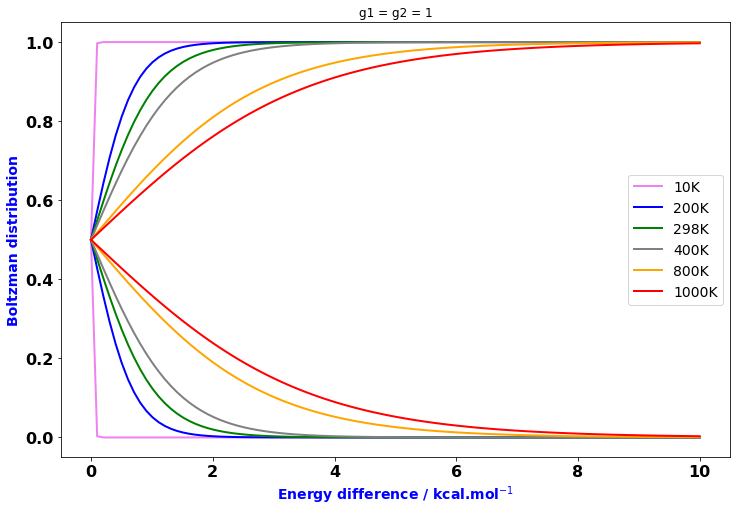

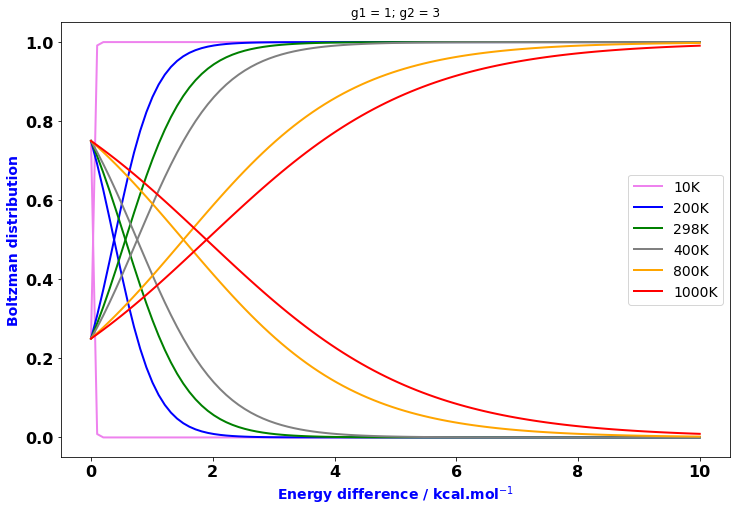

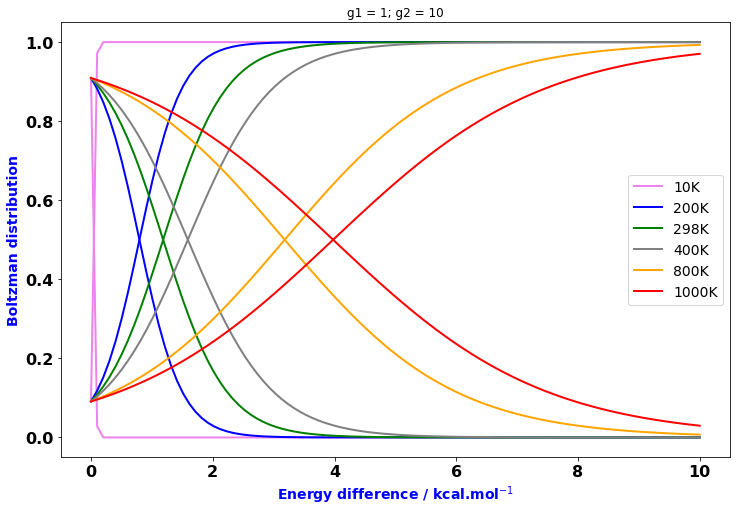

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc



T = 298

def prop2isomers(g1,g2,DE,T):
    '''
    input:
        - DE = energy difference between two isomers in kcal/mol
        - g1 = degeneracy of structure 1
        - g2 = degeneracy of structure 2
        - T = temperature in K
    output: 
        -n1 & n2 = relative proportion of two isomers
    '''
    import scipy.constants as sc
    import numpy as np
    kB = sc.k
    NA = sc.N_A
    cal2J = 4.814
    
    DEJ = DE*1000*cal2J/NA
    boltz = (g2/g1)*np.exp(-DEJ/(kB*T))
    n1 = 1/(1+boltz)
    
    return n1

print(prop2isomers(1,1,0.3,298))

DE = np.linspace(0,10,100)
tabT = np.array([10, 200, 298, 400, 800, 1000])
tabc = ['violet','blue','green','gray','orange','red']
plt.figure(figsize=(12,8))
plt.xlabel('Energy difference / kcal.mol$^{-1}$',size=14,fontweight='bold',color='blue')
plt.ylabel('Boltzman distribution',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
i = 0
for T in  tabT:
    plt.plot(DE,prop2isomers(1,1,DE,T),color=tabc[i],linewidth=2,linestyle='-',label=f"{T}K")
    plt.plot(DE,1-prop2isomers(1,1,DE,T),color=tabc[i],linewidth=2,linestyle='-',)
    i += 1
plt.title("g1 = g2 = 1")
plt.legend(fontsize=14)
plt.show()

plt.figure(figsize=(12,8))
plt.xlabel('Energy difference / kcal.mol$^{-1}$',size=14,fontweight='bold',color='blue')
plt.ylabel('Boltzman distribution',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
i = 0
for T in  tabT:
    plt.plot(DE,prop2isomers(1,3,DE,T),color=tabc[i],linewidth=2,linestyle='-',label=f"{T}K")
    plt.plot(DE,1-prop2isomers(1,3,DE,T),color=tabc[i],linewidth=2,linestyle='-',)
    i += 1
plt.title("g1 = 1; g2 = 3")
plt.legend(fontsize=14)
plt.show()

plt.figure(figsize=(12,8))
plt.xlabel('Energy difference / kcal.mol$^{-1}$',size=14,fontweight='bold',color='blue')
plt.ylabel('Boltzman distribution',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
i = 0
for T in  tabT:
    plt.plot(DE,prop2isomers(1,10,DE,T),color=tabc[i],linewidth=2,linestyle='-',label=f"{T}K")
    plt.plot(DE,1-prop2isomers(1,10,DE,T),color=tabc[i],linewidth=2,linestyle='-',)
    i += 1
plt.title("g1 = 1; g2 = 10")
plt.legend(fontsize=14)
plt.show()

In [34]:
vID.end(cwd0)

**End at:** Monday 20 February 2023, 13:34:49  
**Duration:** 00:00:39 537ms

<p style="text-align: center"><img width="800px" src="../config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>